# Predict Electricity and Gas Utility Production
Build an RNN to predict energy production using the Federal Reserve Economic Database (FRED) Electricity and Gas Utilities Production dataset between Jan 1992 and Jan 2019

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helps plot datetime vals with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


### Import and explore data

In [2]:
df = pd.read_csv('../Data/TimeSeriesData/Energy_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1992,85.5560
1,2/1/1992,80.4178
2,3/1/1992,74.7390
3,4/1/1992,69.8367
4,5/1/1992,67.3781


In [3]:
print('Length of df:', len(df))

Length of df: 325


In [4]:
# Check for nulls
print('Length of df with nulls dropped:', len(df.dropna()))

Length of df with nulls dropped: 325


In [7]:
df.dtypes

DATE           object
IPG2211A2N    float64
dtype: object

In [9]:
# Convert date col from object to datetime
df['DATE'] = pd.to_datetime(df['DATE'])
df.dtypes

DATE          datetime64[ns]
IPG2211A2N           float64
dtype: object

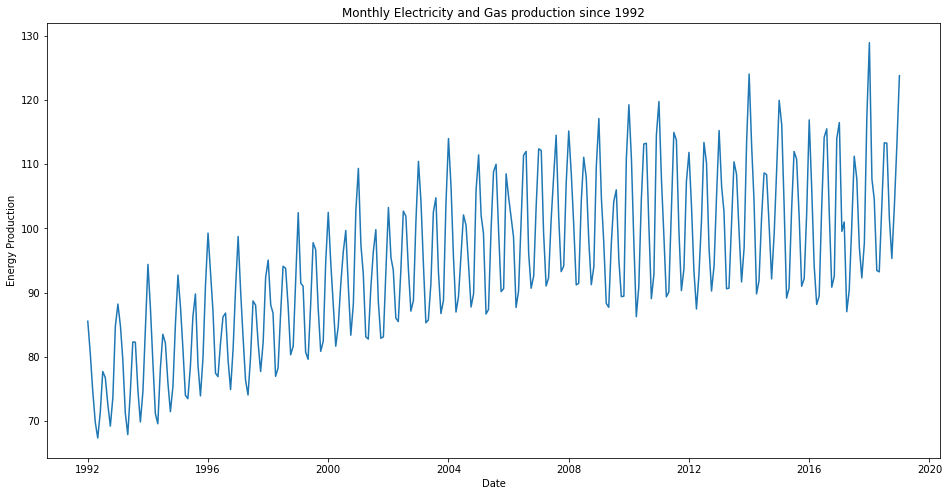

In [19]:
# Plot the data
plt.figure(figsize=(16,8))
plt.plot(df['DATE'], df['IPG2211A2N'])
plt.xlabel('Date')
plt.ylabel('Energy Production')
plt.title('Monthly Electricity and Gas production since 1992')
plt.show()

### Split data

In [37]:
# Energy production vals
y = df['IPG2211A2N'].values

# Test set of 12mo
test_size = 12
train = y[:-test_size]
test = y[-test_size:]
print('Train data before fit:', train[:5])

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train.reshape(-1,1))  # scaler requires 2D vector to fit
train_norm = scaler.transform(train.reshape(-1,1))
train_norm = torch.FloatTensor(train_norm).view(-1)  # flatten out normalized training data
print('Train data after fit:', train_norm[:5])

# Build sequence/prediction data to train model with
window_size = 12
def sequence_data(seq, ws):
    out = []
    for i in range(len(seq)-ws):
        given = seq[i:i+ws]
        pred = seq[i+ws]
        out.append((given,pred))
    return out

train_data = sequence_data(train_norm, window_size)
print('First instance of training data:\n', train_data[0])

Train data before fit: [85.556  80.4178 74.739  69.8367 67.3781]
Train data after fit: tensor([-0.4091, -0.5761, -0.7607, -0.9201, -1.0000])
First instance of training data:
 (tensor([-0.4091, -0.5761, -0.7607, -0.9201, -1.0000, -0.8686, -0.6636, -0.6944,
        -0.8313, -0.9396, -0.7939, -0.4343]), tensor(-0.3223))


### Define model